# Formulation of News Dataset

In [1]:
import pandas as pd
import numpy as np
import missingno as mn

import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

import glob
import os

import abc
import numpy as np

import pandas as pd
import abc
import re
import nltk
from sklearn import model_selection 
from dateutil.parser import parse
from matplotlib import pyplot
import datetime

%matplotlib inline

In [2]:
def createComparableDataset(_df):
    _df.date = pd.to_datetime(_df.date)
    _df = _df[_df['date'] >= pd.to_datetime('2015/05/04')]
    _df = _df[_df['date'] <= pd.to_datetime('2019/03/28')]
    return _df

In [3]:
def getFeaturesAndTargetRemoveDate(_df):
    try:
        train_y = _df['target']
        train = _df.drop(['date','target'],axis =1)
    except:
        train_y = _df['Target']
        train = _df.drop(['date','Target'],axis =1)        
    return train, train_y

In [4]:
def prepareDataSet(_df):
    _df.date = pd.to_datetime(_df.date)
    train = _df[_df['date'] < pd.to_datetime('2019/01/01')]
    test = _df[_df['date'] >= pd.to_datetime('2019/01/01')]
    
    train, train_y = getFeaturesAndTargetRemoveDate(train)
    test, test_y = getFeaturesAndTargetRemoveDate(test)
    return train, train_y,test, test_y

In [5]:
pathOfCwd = os.getcwd()
pathOfCwd
NewsFolder = r'\\MicrosoftNews\\' # use your path
path = pathOfCwd +NewsFolder
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [6]:
frame.dropna(inplace=True, axis='rows')

In [7]:
df = frame.copy()

In [8]:
df['HNA_combine'] = df['Headline'].map(str) + ' ' + df['NewsAbstract'].map(str) 

In [9]:
df.drop(['Headline','NewsAbstract'], axis=1, inplace= True)

In [10]:
dfz = df.groupby(['Date']).agg({'HNA_combine':'-'.join}).reset_index()

In [11]:
dfz.rename(columns={'Date': 'date'}, inplace=True)
dfz['date'] = dfz['date'].apply(
    lambda x: (parse(x).strftime('%Y/%m/%d')))
dfz.head(2)

,date,HNA_combine
0,2005/04/01,On Asia: Why big is not really better ...share...
1,2004/12/01,Lex: Sage ...strong growth and margins compara...


# Appeding Target

In [12]:
targetDF_ = pd.read_csv('FIwithTargetwithFTT.csv')

In [13]:
targtWithDateForJoin =pd.DataFrame()
targtWithDateForJoin['date'] = targetDF_.date.tolist()
targtWithDateForJoin['target'] = targetDF_.Target.tolist()

In [14]:
dfz.date = pd.to_datetime(dfz.date)
targtWithDateForJoin.date = pd.to_datetime(targtWithDateForJoin.date)

In [15]:
result =pd.merge( targtWithDateForJoin,dfz, how='right', on='date')

In [16]:
result['date'] = result['date'].apply(
    lambda x: (parse(str(x)).strftime('%Y/%m/%d')))
result.sort_values(by='date',inplace=True) 

In [17]:
result = result.ffill()
result.fillna(0,inplace=True)

In [18]:
result.shape

(4020, 3)

In [19]:
result.head(4)

,date,target,HNA_combine
0,2004/07/21,1.0,Experts call for ‘circles of trust’ ...Organis...
1,2004/08/02,0.0,Putting gender on the agenda ...compelling pro...
2,2004/08/03,0.0,Look out for the tunnel vision trap ...powerfu...
3,2004/08/04,0.0,Kerry displays business credentials in swipe a...


In [20]:
result = createComparableDataset(result)

In [21]:
result.shape

(1027, 3)

In [22]:
result.head(4)

,date,target,HNA_combine
2442,2015-05-04,0.0,Cisco Systems: re-routing ...Networks and Glob...
2443,2015-05-05,0.0,Time to end Europe’s dependence on Russian ene...
2444,2015-05-06,0.0,Gates pledges $75m to probe child deaths ...Mi...
2445,2015-05-07,0.0,Fintech finds new friends ...technologists awa...


In [23]:
train, train_y,test, test_y = prepareDataSet(result)
print('train',train.shape,'test',test.shape,'train_y',len(train_y),'test_y',len(test_y))

train (961, 1) test (66, 1) train_y 961 test_y 66


In [24]:
train.head(2)

,HNA_combine
2442,Cisco Systems: re-routing ...Networks and Glob...
2443,Time to end Europe’s dependence on Russian ene...


# UlmFit

In [25]:
from fastai.text import *
import html

In [26]:
trn_texts = train.HNA_combine.values
trn_labels = train_y.to_numpy()
val_texts = test.HNA_combine.values
val_labels = test_y.to_numpy()

In [27]:
col_names = ['labels','text']
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [31]:
df_trn.to_csv('training.csv', index =None)
df_val.to_csv('testing.csv', index =None)

In [28]:
df_trn['labels'].value_counts()

1.0    526
0.0    435
Name: labels, dtype: int64

In [29]:
df_val['labels'].value_counts()

1.0    37
0.0    29
Name: labels, dtype: int64

In [30]:
# Language model data
data_lm = TextLMDataBunch.from_df('./', train_df=df_trn, valid_df=df_val)

In [36]:
# save and load
data_lm.save('tmp_lm')
# data_lm = TextClasDataBunch.load('./', 'tmp_lm')

In [37]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('./', train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [38]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, pretrained=True, drop_mult=0.5)

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


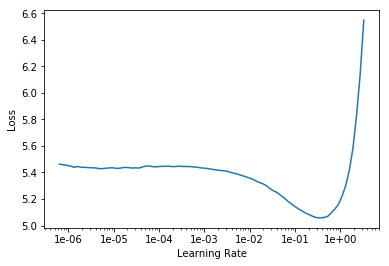

In [40]:
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.910716,4.318453,0.266183,02:42


In [42]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.330081,4.035757,0.295313,05:30


In [43]:
learn.predict("Microsoft stock price", n_words=10)

'Microsoft stock price rises as president meet every close to partially above expectations'

In [44]:
learn.save_encoder('ft_enc')

In [45]:
classifier = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.2)
classifier.load_encoder('ft_enc')

In [46]:
data_clas.show_batch()

text,target
"xxbos xxmaj tech giants drive market to yet another record ... xxup us stocks clinched their xxunk record closing high of the year on xxmaj friday after a surge in the shares of a coterie of technology companies following stronger than expected earnings . \n xxmaj amazon , xxmaj microsoft ... -uber hires doj and xxmaj pepsi veteran as chief lawyer ... xxmaj francisco xxmaj bay xxmaj area native",1.0
"xxbos xxmaj fast xxmaj asia xxmaj open : xxmaj markets stay xxunk ... cent lower and the xxmaj nasdaq xxmaj composite slipped 0.9 per cent , with xxmaj microsoft ’s $ 26.2bn deal to buy linkedin unable to boost the mood . xxmaj shares in xxmaj microsoft fell 2.6 per cent . \n xxmaj oil prices remained in negative ... -firstft : xxmaj terrorism moves to xxup us",0.0
"xxbos xxmaj euro hits xxunk low against the dollar ... central banks . \n xxmaj in xxmaj new xxmaj york , the xxup s&p 500 recovered from an early dip to close flat at xxunk , as investors xxunk earnings reports from xxmaj microsoft and xxmaj general xxmaj electric . \n xxmaj wall xxmaj street stocks also ... -nintendo hints at key shift in focus with xxmaj switch",1.0
"xxbos xxmaj fast xxmaj asia xxmaj open : xxmaj australia auto sales , s xxmaj korea money supply ... networked machines communicate with each other in older versions of xxmaj microsoft ’s xxmaj windows software . \n xxmaj but on xxmaj monday , the wannacry attack , which hit 200,000 computers across 150 countries , appeared to slow . xxmaj xxunk ... xxunk founder puts xxunk analysis on farm",0.0
"xxbos xxmaj pound falls as weak xxup uk xxup gdp data damp rate rise talk ... xxmaj european peers . \n xxmaj wall xxmaj street put in a more cautious performance following the solid rise recorded on xxmaj thursday . \n xxmaj results - driven gains for xxmaj amazon and xxmaj microsoft , with shares in the former hitting a record ... -amazon gets trillion dollar valuation from",1.0


In [47]:
classifier.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,0.408566,0.259595,02:45


In [48]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,time
0,0.269137,0.253210,03:39


In [49]:
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,time
0,0.207138,0.271592,10:47


In [53]:
classifier.predict("Stock Price of Microsoft will go down in coming future.")

C:\Users\praveen ji\Anaconda3\envs\tf_gpu\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(FloatItem [0.772456], tensor([0.7725]), tensor([0.7725]))

In [54]:
#confusion matrix

In [ ]:
from fastai.vision import *

In [57]:
preds, y, losses = classifier.get_preds(with_loss= True)
# interp =ClassificationInterpretation(data_clas,preds,y,losses)

In [90]:
yHat = preds.numpy()
yHat = np.rint(np.squeeze(yHat))

y = y.numpy()
y = np.rint(np.squeeze(y))

In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [98]:
print(classification_report(yHat,y))

              precision    recall  f1-score   support

         0.0       0.17      0.42      0.24        12
         1.0       0.81      0.56      0.66        54

   micro avg       0.53      0.53      0.53        66
   macro avg       0.49      0.49      0.45        66
weighted avg       0.69      0.53      0.58        66



In [113]:
accuracy_score(yHat,y)

0.5303030303030303